In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
#from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [2]:
raw_data = yfinance.download (tickers = "BTC-USD LTC-USD ETH-USD XLM-USD XMR-USD", start = "2016-01-01", 
                              end = "2021-10-01", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  5 of 5 completed


In [3]:
df_comp = raw_data.copy()

In [4]:
df_comp['btc'] = df_comp['BTC-USD'].Close[:]
df_comp['ltc'] = df_comp['LTC-USD'].Close[:]
df_comp['eth'] = df_comp['ETH-USD'].Close[:]
df_comp['xlm'] = df_comp['XLM-USD'].Close[:]
df_comp['xmr'] = df_comp['XMR-USD'].Close[:]

In [5]:
df_comp = df_comp.iloc[1:]
del df_comp['BTC-USD']
del df_comp['LTC-USD']
del df_comp['ETH-USD']
del df_comp['XLM-USD']
del df_comp['XMR-USD']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [6]:
df_comp

,btc,ltc,eth,xlm,xmr
,,,,,
Date,,,,,
2016-01-04,433.091003,3.495390,0.954480,0.001748,0.517388
2016-01-05,431.959991,3.469670,0.950176,0.001721,0.499272
2016-01-06,429.105011,3.453560,0.950860,0.001672,0.505053
2016-01-07,458.048004,3.604140,0.942005,0.001728,0.492529
2016-01-08,453.230011,3.568880,0.986789,0.001681,0.488417
...,...,...,...,...,...
2021-09-27,42235.730469,145.349579,2934.138916,0.265834,234.729599
2021-09-28,41034.542969,140.597122,2807.296631,0.256740,229.600311


# Creando retornos

In [7]:
df_comp['ret_btc'] = df_comp.btc.pct_change(1).mul(100)
df_comp['ret_ltc'] = df_comp.ltc.pct_change(1).mul(100)
df_comp['norm_ret_btc'] = df_comp.ret_btc.div(df_comp.ret_btc[1])*100
df_comp['norm_ret_ltc'] = df_comp.ret_ltc.div(df_comp.ret_ltc[1])*100

## Creando pruebas

In [8]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [9]:
start_date = "2016-01-01"
end_date = "2022-01-01"

## Prueba autoarima

In [10]:
model_auto = auto_arima(df.ret_btc[1:], exogenous = df[['ret_ltc']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [11]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1199
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -3281.390
Date:                Mon, 04 Oct 2021   AIC                           6574.780
Time:                        17:37:17   BIC                           6605.315
Sample:                    01-05-2016   HQIC                          6586.283
                         - 08-07-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2082      0.117      1.773      0.076      -0.022       0.438
ret_ltc        0.4056      0.007     60.762      0.000       0.393       0.419
ar.L1          0.0458      0.014      3.292      0.001       0.019       0.073
ar.L2          0.0080      0.016      0.487      0.626      -0.024       0.040
ar.L3         -0.1084      0.021     -5.156      0.000      -0.150      -0.067
sigma2        13.9517      0.244     57.100      0.000      13.473      14.431
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6285.12
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.14
Prob(H) (two-sided):                  0.06   Kurtosis:                        14.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_ltc']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

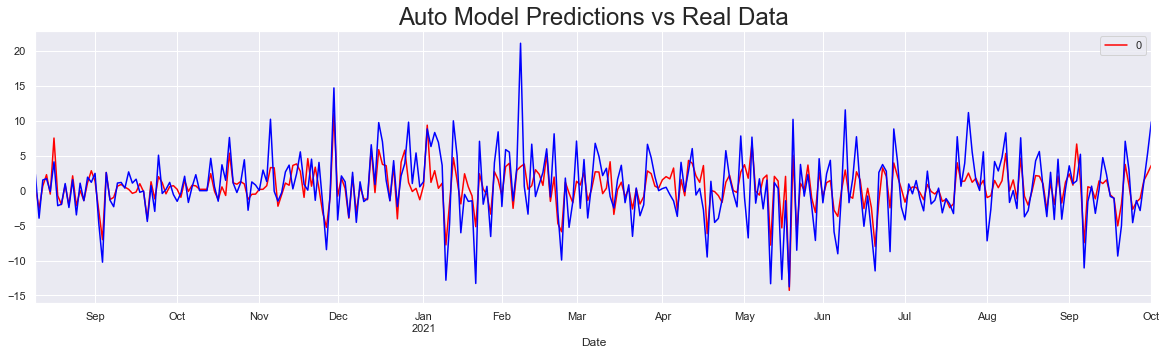

In [13]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_btc[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

In [14]:
df_auto_pred

,0
Date,
2020-08-10,0.528986
2020-08-11,-2.536928
2020-08-12,0.670038
2020-08-13,2.289141
2020-08-14,-0.492228
...,...
2021-09-27,-1.636203
2021-09-28,-1.128738
2021-09-29,1.444077


## Prueba Arima 212

In [15]:
model_auto2 = auto_arima(df.btc, exogenous = df[['ltc']],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [16]:
model_auto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1200
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -8570.376
Date:                Mon, 04 Oct 2021   AIC                          17152.751
Time:                        17:38:24   BIC                          17183.287
Sample:                    01-04-2016   HQIC                         17164.254
                         - 08-07-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ltc           30.1874      0.483     62.457      0.000      29.240      31.135
ar.L1          1.1308      0.017     68.058      0.000       1.098       1.163
ar.L2         -0.9297      0.014    -68.677      0.000      -0.956      -0.903
ma.L1         -1.0653      0.020    -53.128      0.000      -1.105      -1.026
ma.L2          0.8445      0.019     43.489      0.000       0.806       0.883
sigma2      9.747e+04   1111.279     87.711      0.000    9.53e+04    9.96e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             50921.68
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              49.64   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
df_auto_pred2 = pd.DataFrame(model_auto2.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ltc']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

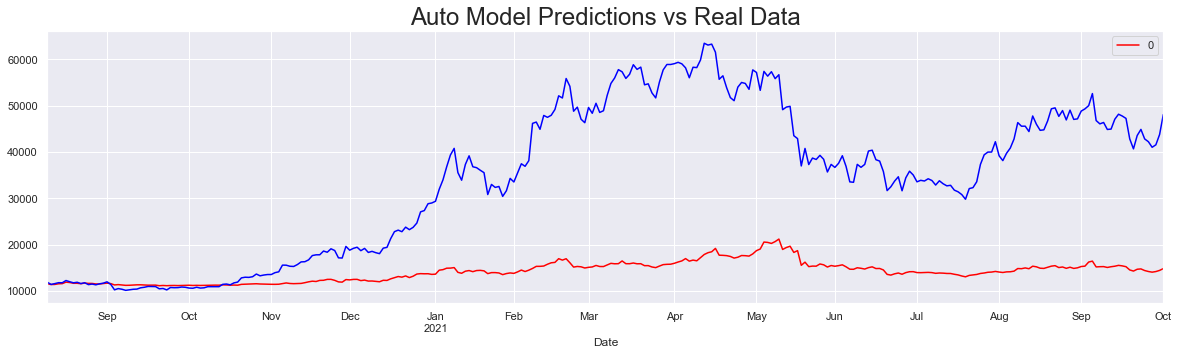

In [18]:
df_auto_pred2.plot(figsize = (20,5), color = "red")
df_test.btc[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

In [19]:
df_btc_model = auto_arima(df.btc, exogenous = df[['ltc', 'eth', 'xlm','xmr']],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [20]:
df_btc_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1200
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -8478.326
Date:                Mon, 04 Oct 2021   AIC                          16982.653
Time:                        17:42:49   BIC                          17048.813
Sample:                    01-04-2016   HQIC                         17007.576
                         - 08-07-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ltc           16.5012      0.543     30.400      0.000      15.437      17.565
eth            2.7421      0.251     10.917      0.000       2.250       3.234
xlm          881.2934    282.745      3.117      0.002     327.124    1435.463
xmr            9.5404      0.710     13.446      0.000       8.150      10.931
ar.L1         -0.2655      0.037     -7.252      0.000      -0.337      -0.194
ar.L2         -0.2108      0.034     -6.160      0.000      -0.278      -0.144
ar.L3         -0.2804      0.029     -9.773      0.000      -0.337      -0.224
ar.L4         -0.8861      0.033    -27.161      0.000      -0.950      -0.822
ma.L1          0.2970      0.040      7.409      0.000       0.218       0.376
ma.L2          0.1603      0.038      4.207      0.000       0.086       0.235
ma.L3          0.2319      0.036      6.515      0.000       0.162       0.302
ma.L4          0.7782      0.040     19.249      0.000       0.699       0.857
sigma2      8.314e+04    982.035     84.659      0.000    8.12e+04    8.51e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             63691.54
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              48.95   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
df_auto_pred_btc = pd.DataFrame(df_btc_model.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ltc', 'eth', 'xlm', 'xmr']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

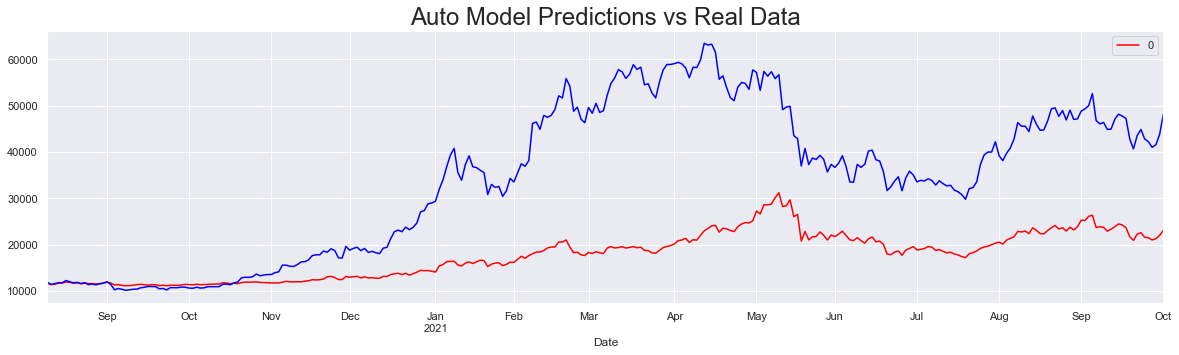

In [22]:
df_auto_pred_btc.plot(figsize = (20,5), color = "red")
df_test.btc[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()